In [31]:
import GEOparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
# Load the GEO dataset (replace 'GSE14020' with the correct dataset ID if needed)
gse = GEOparse.get_GEO("GSE14020", destdir="./")

# Extract expression data for all samples
pivot_all_samples = gse.pivot_samples("VALUE")  # This creates a DataFrame of gene expression values

08-Nov-2024 14:41:54 DEBUG utils - Directory ./ already exists. Skipping.
08-Nov-2024 14:41:54 INFO GEOparse - File already exist: using local version.
08-Nov-2024 14:41:54 INFO GEOparse - Parsing ./GSE14020_family.soft.gz: 
08-Nov-2024 14:41:54 DEBUG GEOparse - DATABASE: GeoMiame
08-Nov-2024 14:41:54 DEBUG GEOparse - SERIES: GSE14020
08-Nov-2024 14:41:54 DEBUG GEOparse - PLATFORM: GPL96
08-Nov-2024 14:41:55 DEBUG GEOparse - PLATFORM: GPL570
/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
08-Nov-2024 14:41:56 DEBUG GEOparse - SAMPLE: GSM352095
08-Nov-2024 14:41:56 DEBUG GEOparse - SAMPLE: GSM352097
08-Nov-2024 14:41:56 DEBUG GEOparse - SAMPLE: GSM352098
08-Nov-2024 14:41:56 DEBUG GEOparse - SAMPLE: GSM352100
08-Nov-2024 14:41:56 DEBUG GEOparse - SAMPLE: GSM352101
08-Nov-2024 14:41:56 DE

In [33]:
# Annotate samples with GPL data for GPL570 platform
samples = pivot_all_samples
lfc_result_annotated = samples.reset_index().merge(
    gse.gpls['GPL570'].table[["ID", "ENTREZ_GENE_ID", "Gene Symbol"]],
    left_on='ID_REF', right_on="ID"
)
lfc_result_annotated.head()

,ID_REF,GSM352095,GSM352097,GSM352098,GSM352100,GSM352101,GSM352103,GSM352105,GSM352107,GSM352109,...,GSM352162,GSM352163,GSM352164,GSM352165,GSM352166,GSM352167,GSM352168,ID,ENTREZ_GENE_ID,Gene Symbol
0,1007_s_at,11.942972,12.028198,12.359949,11.589025,11.405878,10.658286,10.835002,12.091930,12.085872,...,11.531553,10.615657,10.253499,11.060955,10.999642,9.523839,10.644172,1007_s_at,780 /// 100616237,DDR1 /// MIR4640
1,1053_at,9.124514,9.478611,8.936268,8.035468,9.168375,8.102512,9.247241,9.189113,8.306166,...,7.023597,7.014296,6.999848,7.609674,6.644695,6.741417,6.826809,1053_at,5982,RFC2
2,117_at,7.832843,8.056224,8.230384,10.979582,7.907716,8.983309,9.381022,7.796607,8.537037,...,7.617238,7.877476,7.746652,7.653508,7.794672,8.241767,8.210786,117_at,3310,HSPA6
3,121_at,9.293999,9.734242,9.196800,9.359527,9.449023,9.438934,9.383646,9.080720,9.423481,...,9.201497,9.318078,8.943775,9.081481,9.145070,9.340316,9.089787,121_at,7849,PAX8
4,1255_g_at,4.545640,4.589639,4.443698,4.633253,4.698722,4.755724,4.530701,4.644450,4.574697,...,4.965196,5.101353,4.862778,4.880778,4.906529,4.975271,5.329008,1255_g_at,2978,GUCA1A


In [34]:
# Initialize a dictionary to store metastasis site information
sample_metadata = {}

# Loop through each sample and extract metastasis site information
for gsm_id, gsm_data in gse.gsms.items():
    source_name = gsm_data.metadata.get("source_name_ch1", [""])[0]
    if "Lung" in source_name:
        sample_metadata[gsm_id] = "Lung"
    elif "Brain" in source_name:
        sample_metadata[gsm_id] = "Brain"
    elif "Bone" in source_name:
        sample_metadata[gsm_id] = "Bone"
    elif "Liver" in source_name:
        sample_metadata[gsm_id] = "Liver"
    else:
        sample_metadata[gsm_id] = "Unknown"  # Label samples with no clear site info as Unknown

# Convert metadata to DataFrame for merging
sample_metadata_df = pd.DataFrame(list(sample_metadata.items()), columns=["Sample", "Metastasis_Site"])
sample_metadata_df.head()

,Sample,Metastasis_Site
0,GSM352095,Lung
1,GSM352097,Brain
2,GSM352098,Brain
3,GSM352100,Bone
4,GSM352101,Brain


In [35]:
# Merge expression data with sample metadata
filtered_samples = lfc_result_annotated.set_index("ID_REF").T
filtered_samples = filtered_samples.merge(sample_metadata_df, left_index=True, right_on="Sample")
filtered_samples = filtered_samples.set_index("Sample")

# Filter out samples labeled as "Unknown" for metastasis site
filtered_samples = filtered_samples[filtered_samples["Metastasis_Site"] != "Unknown"]

# Handle NaN values by imputing with the mean of each column
from sklearn.impute import SimpleImputer

# Impute missing values with column means
imputer = SimpleImputer(strategy="mean")
imputed_data = imputer.fit_transform(filtered_samples.drop(columns="Metastasis_Site"))
imputed_data = pd.DataFrame(imputed_data, columns=filtered_samples.columns[:-1], index=filtered_samples.index)
imputed_data["Metastasis_Site"] = filtered_samples["Metastasis_Site"]

# Verify that the data is not empty after preprocessing
print("Shape of imputed_data:", imputed_data.shape)
print("Metastasis Site Distribution:", imputed_data["Metastasis_Site"].value_counts())

Shape of imputed_data: (65, 54676)
Metastasis Site Distribution: Metastasis_Site
Brain    22
Lung     20
Bone     18
Liver     5
Name: count, dtype: int64


In [36]:
# Separate features (X) and labels (y)
X = imputed_data.drop(columns="Metastasis_Site")
y = imputed_data["Metastasis_Site"]

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Bone': 0, 'Brain': 1, 'Liver': 2, 'Lung': 3}


In [37]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

# Print evaluation metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Random Forest Recall:", recall_score(y_test, y_pred_rf, average='weighted'))

Random Forest Classification Report:
              precision    recall  f1-score   support

        Bone       0.75      0.75      0.75         4
       Brain       1.00      1.00      1.00         4
       Liver       1.00      1.00      1.00         1
        Lung       0.75      0.75      0.75         4

    accuracy                           0.85        13
   macro avg       0.88      0.88      0.88        13
weighted avg       0.85      0.85      0.85        13

Random Forest Accuracy: 0.8461538461538461
Random Forest Precision: 0.8461538461538461
Random Forest Recall: 0.8461538461538461


In [38]:
# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', C=1, random_state=42)  # Use rbf kernel for good classification performance
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)

# Print evaluation metrics
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("SVM Recall:", recall_score(y_test, y_pred_svm, average='weighted'))

SVM Classification Report:
              precision    recall  f1-score   support

        Bone       1.00      0.25      0.40         4
       Brain       0.60      0.75      0.67         4
       Liver       0.00      0.00      0.00         1
        Lung       0.43      0.75      0.55         4

    accuracy                           0.54        13
   macro avg       0.51      0.44      0.40        13
weighted avg       0.62      0.54      0.50        13

SVM Accuracy: 0.5384615384615384
SVM Precision: 0.6241758241758242
SVM Recall: 0.5384615384615384


/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [39]:
# Define the neural network model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=len(label_mapping), activation='softmax')
])

# Compile the neural network model
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train the neural network model
history = ann.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=100, batch_size=32, callbacks=callbacks)

# Evaluate the model on the test set
test_loss, test_accuracy = ann.evaluate(X_test, y_test)
print("Neural Network Test Accuracy:", test_accuracy)

Epoch 1/100


/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.2604 - loss: 2.0494 - val_accuracy: 0.4615 - val_loss: 1.0987 - learning_rate: 1.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4359 - loss: 1.6500 - val_accuracy: 0.7692 - val_loss: 0.6602 - learning_rate: 1.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5905 - loss: 0.9345 - val_accuracy: 0.7692 - val_loss: 0.5168 - learning_rate: 1.0000e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5849 - loss: 1.1075 - val_accuracy: 0.7692 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5873 - loss: 1.2270 - val_accuracy: 0.8462 - val_loss: 0.3986 - learning_rate: 1.0000e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6883 - loss: 1.0373 - val_accuracy: 0.9231 - val_loss: 0.3507 - learning_rate: 1.0000e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.7546 - v

In [40]:
# Collect accuracy scores for each model
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))
_, nn_accuracy = ann.evaluate(X_test, y_test)

print("\nModel Accuracies:")
print("Random Forest Accuracy:", rf_accuracy*100)
print("SVM Accuracy:", svm_accuracy*100)
print("Neural Network Accuracy:", nn_accuracy*100)

# Choose the model with the highest accuracy
accuracies = {'Random Forest': rf_accuracy, 'SVM': svm_accuracy, 'Neural Network': nn_accuracy}
best_model_name = max(accuracies, key=accuracies.get)
print(f"\nBest Model: {best_model_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.1711

Model Accuracies:
Random Forest Accuracy: 84.61538461538461
SVM Accuracy: 53.84615384615385
Neural Network Accuracy: 100.0

Best Model: Neural Network


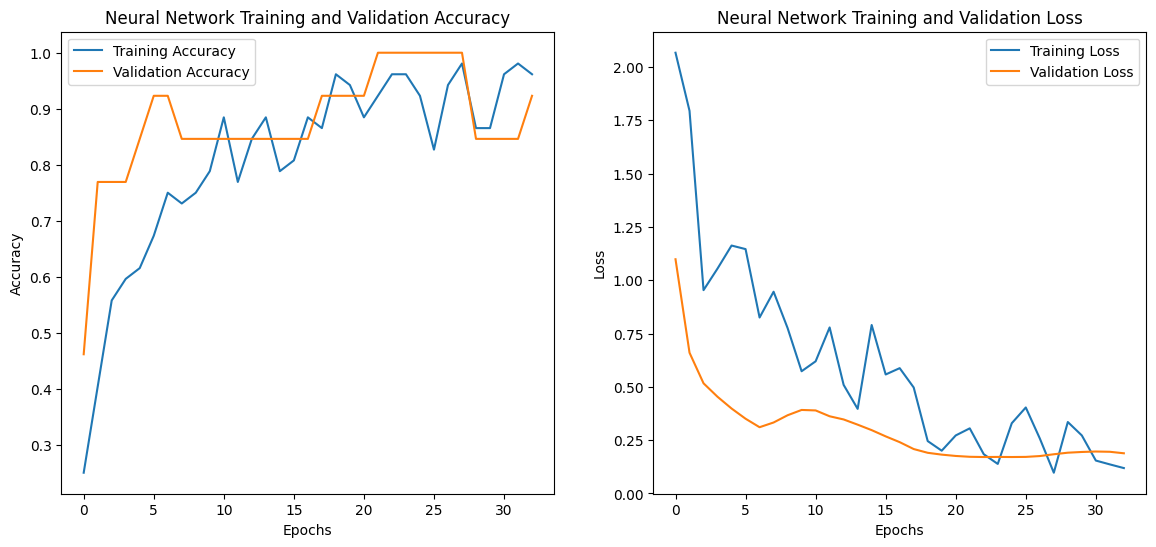

In [41]:
if best_model_name == "Neural Network":
    # Plot accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Neural Network Training and Validation Accuracy")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Neural Network Training and Validation Loss")
    plt.show()


In [42]:
# Train Random Forest to get feature importance
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Get feature importances from Random Forest model
feature_importances = rf_model.feature_importances_

# Get the indices of the top 9 features
top9_indices = np.argsort(feature_importances)[-9:][::-1]  # Get indices of top 9 features in descending order

# Get the names of the top 9 genes
top9_genes = X.columns[top9_indices]
top9_importances = feature_importances[top9_indices]

# Print top 9 genes with their importance scores
print("Top 9 Genes and Their Importance Scores:")
for gene, importance in zip(top9_genes, top9_importances):
    print(f"{gene}: {importance:.4f}")

Top 9 Genes and Their Importance Scores:
210072_at: 0.0126
205030_at: 0.0086
202765_s_at: 0.0083
209671_x_at: 0.0071
210091_s_at: 0.0068
211668_s_at: 0.0065
206683_at: 0.0063
202458_at: 0.0061
202403_s_at: 0.0061


In [43]:
# Assuming `lfc_result_annotated` contains the mapping of probe IDs to gene symbols
# Filter for only the top 9 probes
top9_probe_ids = top9_genes  # These are the probe IDs from Random Forest feature importance
top9_genes_info = lfc_result_annotated[lfc_result_annotated['ID_REF'].isin(top9_probe_ids)][['ID_REF', 'Gene Symbol']]

# Merge top 9 probes with their gene symbols for easy display
top9_genes_info = top9_genes_info.drop_duplicates().set_index('ID_REF').reindex(top9_probe_ids)

# Print the gene names alongside their importance scores
print("Top 9 Genes with Probe IDs, Gene Symbols, and Importance Scores:")
for probe_id, importance in zip(top9_probe_ids, top9_importances):
    gene_symbol = top9_genes_info.loc[probe_id, 'Gene Symbol'] if probe_id in top9_genes_info.index else 'Unknown'
    print(f"Probe ID: {probe_id}, Gene Symbol: {gene_symbol}, Importance Score: {importance:.4f}")


Top 9 Genes with Probe IDs, Gene Symbols, and Importance Scores:
Probe ID: 210072_at, Gene Symbol: CCL19, Importance Score: 0.0126
Probe ID: 205030_at, Gene Symbol: FABP7, Importance Score: 0.0086
Probe ID: 202765_s_at, Gene Symbol: FBN1, Importance Score: 0.0083
Probe ID: 209671_x_at, Gene Symbol: TRAC, Importance Score: 0.0071
Probe ID: 210091_s_at, Gene Symbol: DTNA, Importance Score: 0.0068
Probe ID: 211668_s_at, Gene Symbol: PLAU, Importance Score: 0.0065
Probe ID: 206683_at, Gene Symbol: ZNF165, Importance Score: 0.0063
Probe ID: 202458_at, Gene Symbol: PRSS23, Importance Score: 0.0061
Probe ID: 202403_s_at, Gene Symbol: COL1A2, Importance Score: 0.0061


In [44]:
# Select only the top 9 important features from the training and testing sets
X_train_top9 = X_train[:, top9_indices]
X_test_top9 = X_test[:, top9_indices]

# Train a new Random Forest model using only the top 9 features
rf_model_top9 = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_top9.fit(X_train_top9, y_train)

from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set with the top 9 features
y_pred_top9 = rf_model_top9.predict(X_test_top9)

# Calculate accuracy
accuracy_top9 = accuracy_score(y_test, y_pred_top9)
print("Accuracy with Top 9 Features:", accuracy_top9)

# Print classification report for detailed performance metrics
print("\nClassification Report with Top 9 Features:\n")
print(classification_report(y_test, y_pred_top9, target_names=label_encoder.classes_))

Accuracy with Top 9 Features: 0.8461538461538461

Classification Report with Top 9 Features:

              precision    recall  f1-score   support

        Bone       0.80      1.00      0.89         4
       Brain       1.00      1.00      1.00         4
       Liver       0.00      0.00      0.00         1
        Lung       0.75      0.75      0.75         4

    accuracy                           0.85        13
   macro avg       0.64      0.69      0.66        13
weighted avg       0.78      0.85      0.81        13



/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nidhi/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

/var/folders/35/vtt48s7n245768zj9fh23ybw0000gn/T/ipykernel_2409/1682744156.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top9_df["Metastasis_Site"] = y_df.values  # Add the target variable


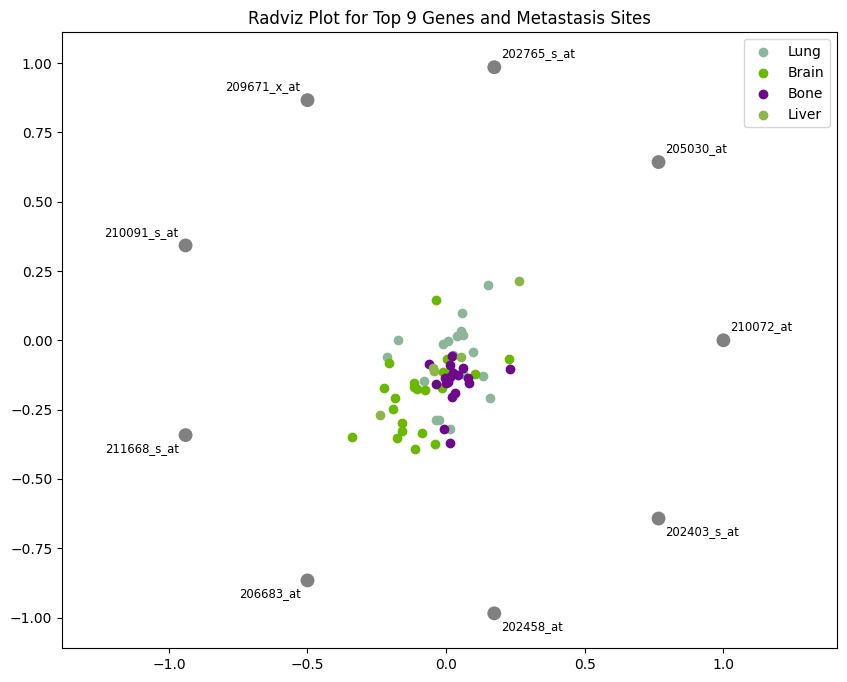

In [45]:
from pandas.plotting import radviz

# Assuming X is initially a numpy array, convert X to DataFrame with feature names
X_df = pd.DataFrame(X, columns=filtered_samples.columns[:-1])  # Exclude the target column
y_df = pd.Series(y, name="Metastasis_Site")  # Convert target to a Series for consistency

# Select only the top 9 important features based on indices
X_top9_df = X_df.iloc[:, top9_indices]  # Select columns by index for top 9 features
X_top9_df["Metastasis_Site"] = y_df.values  # Add the target variable

# Create the Radviz plot
plt.figure(figsize=(10, 8))
radviz(X_top9_df, "Metastasis_Site")
plt.title("Radviz Plot for Top 9 Genes and Metastasis Sites")
plt.show()

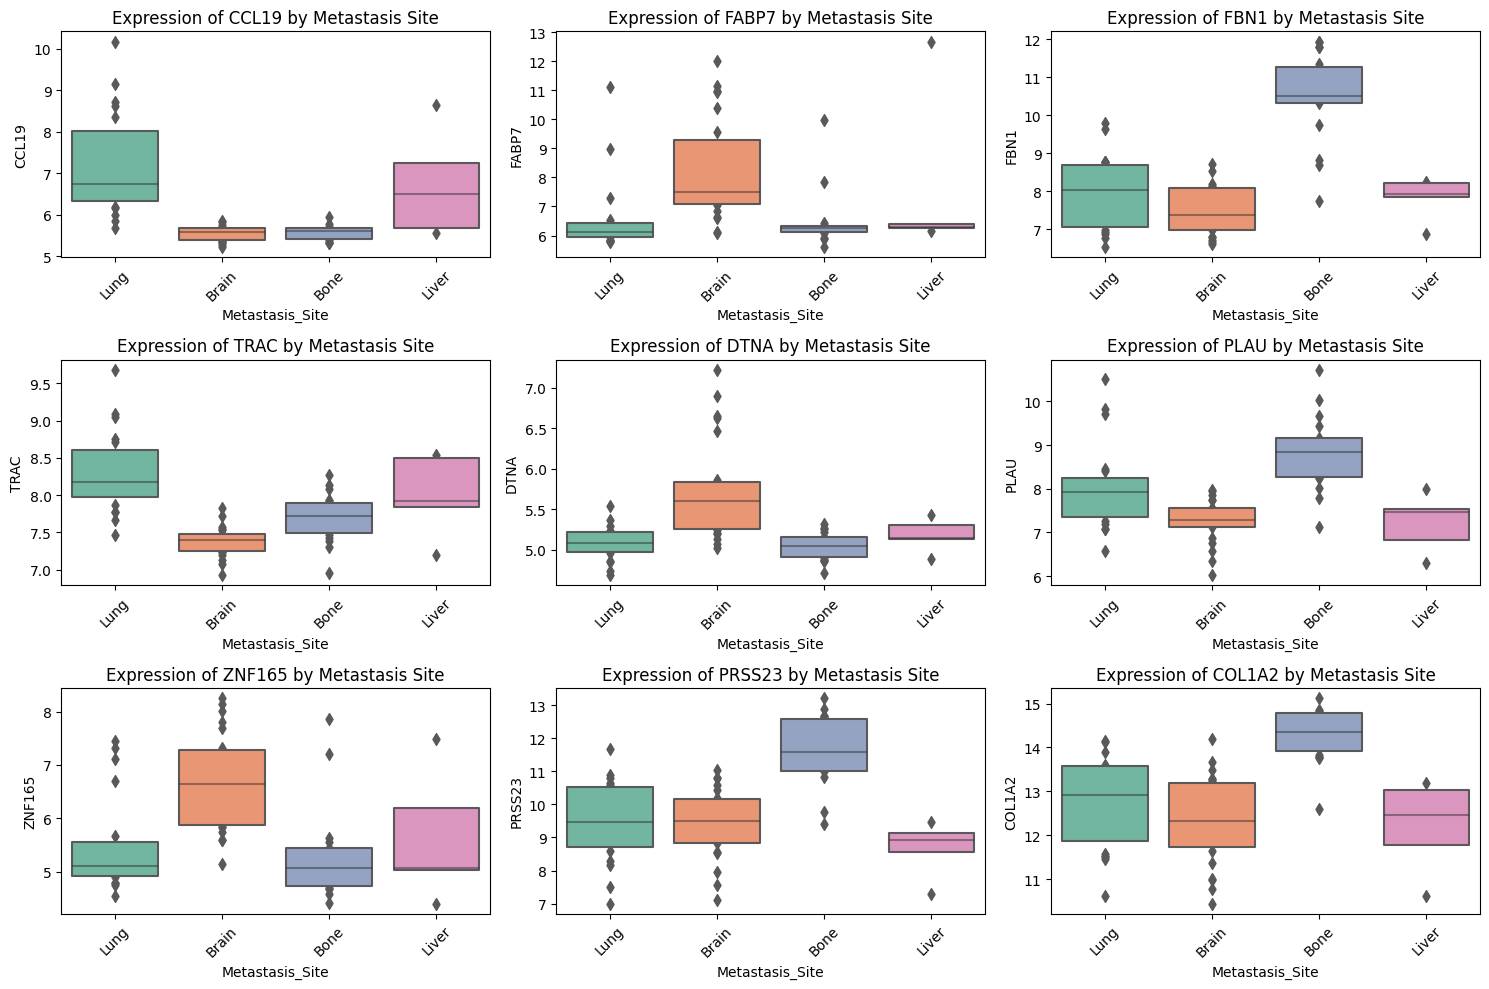

In [58]:
plt.figure(figsize=(15, 10))
for i, gene in enumerate(X_top9_df.columns[:-1], 1):  # Exclude target column
    plt.subplot(3, 3, i)
    sns.boxenplot(x="Metastasis_Site", y=gene, data=X_top9_df, palette="Set2")
    plt.title(f"Expression of {gene} by Metastasis Site")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


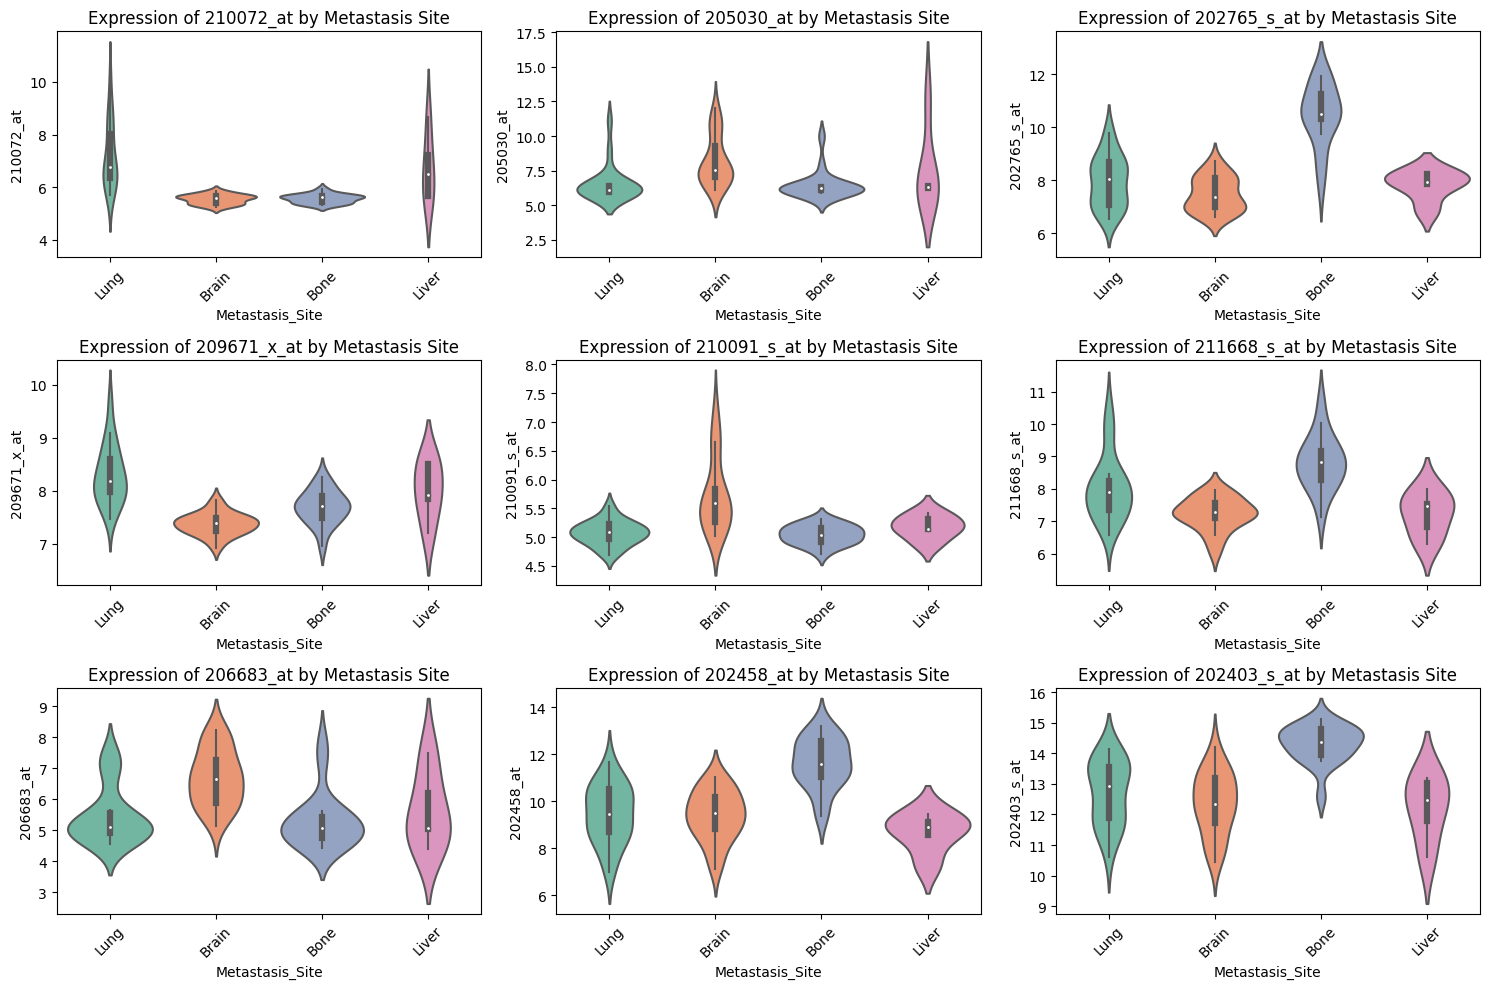

In [47]:
plt.figure(figsize=(15, 10))
for i, gene in enumerate(X_top9_df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x="Metastasis_Site", y=gene, data=X_top9_df, palette="Set2")
    plt.title(f"Expression of {gene} by Metastasis Site")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


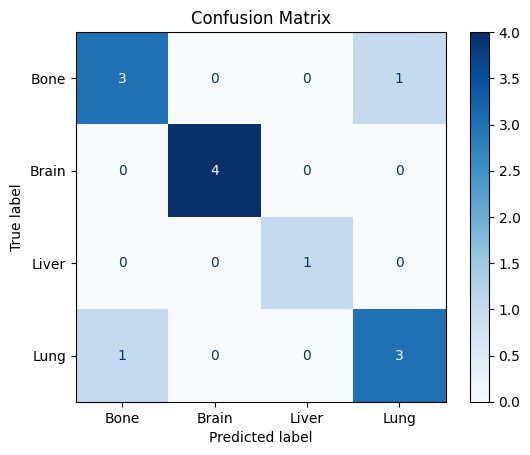

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = rf_model.predict(X_test)  # Replace rf_model with your chosen model if necessary

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


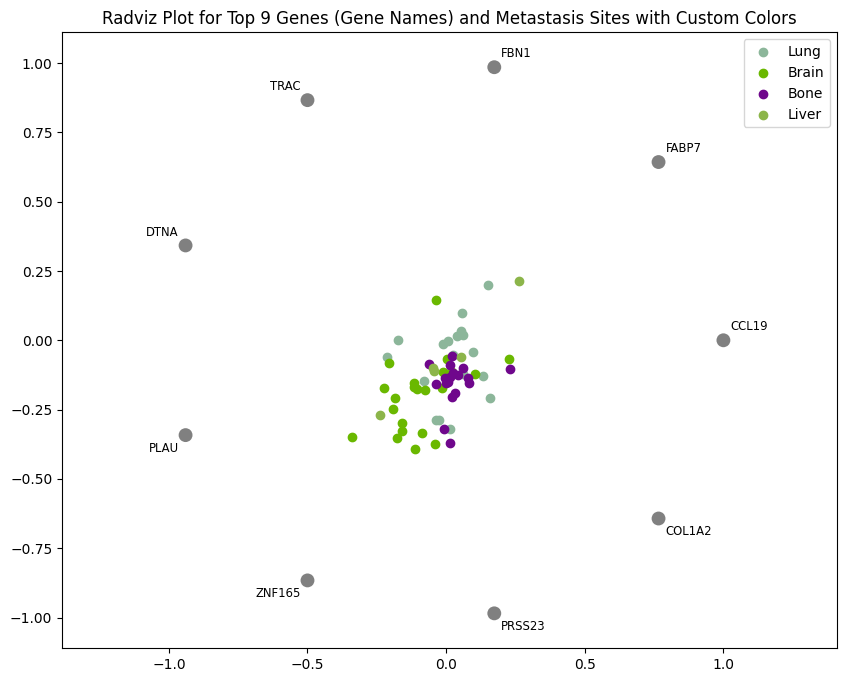

In [49]:
import matplotlib.pyplot as plt
from pandas.plotting import radviz

# Assuming `lfc_result_annotated` has the mapping between gene IDs and gene names
# Extract a dictionary mapping from 'ID_REF' (gene IDs) to 'Gene Symbol' (gene names)
gene_id_to_name = lfc_result_annotated.set_index("ID_REF")["Gene Symbol"].to_dict()

# Replace gene IDs with gene names in X_top9_df
X_top9_df = X_top9_df.rename(columns=gene_id_to_name)

# Add the target variable 'Metastasis_Site' to X_top9_df if not already added
X_top9_df["Metastasis_Site"] = y_df.values  # Assuming y_df contains the metastasis site labels


# Plot the Radviz with gene names as anchors and custom colors for each metastasis site
plt.figure(figsize=(10, 8))
radviz(X_top9_df, "Metastasis_Site")
plt.title("Radviz Plot for Top 9 Genes (Gene Names) and Metastasis Sites with Custom Colors")
plt.show()


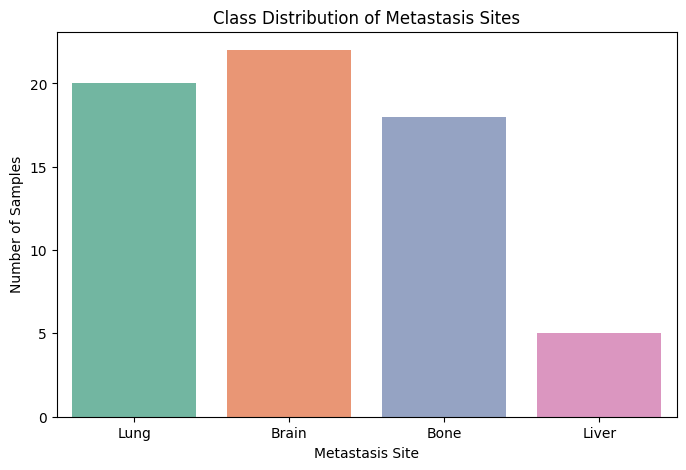

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution for metastasis sites
plt.figure(figsize=(8, 5))
sns.countplot(x="Metastasis_Site", data=X_top9_df, palette="Set2")
plt.title("Class Distribution of Metastasis Sites")
plt.xlabel("Metastasis Site")
plt.ylabel("Number of Samples")
plt.show()


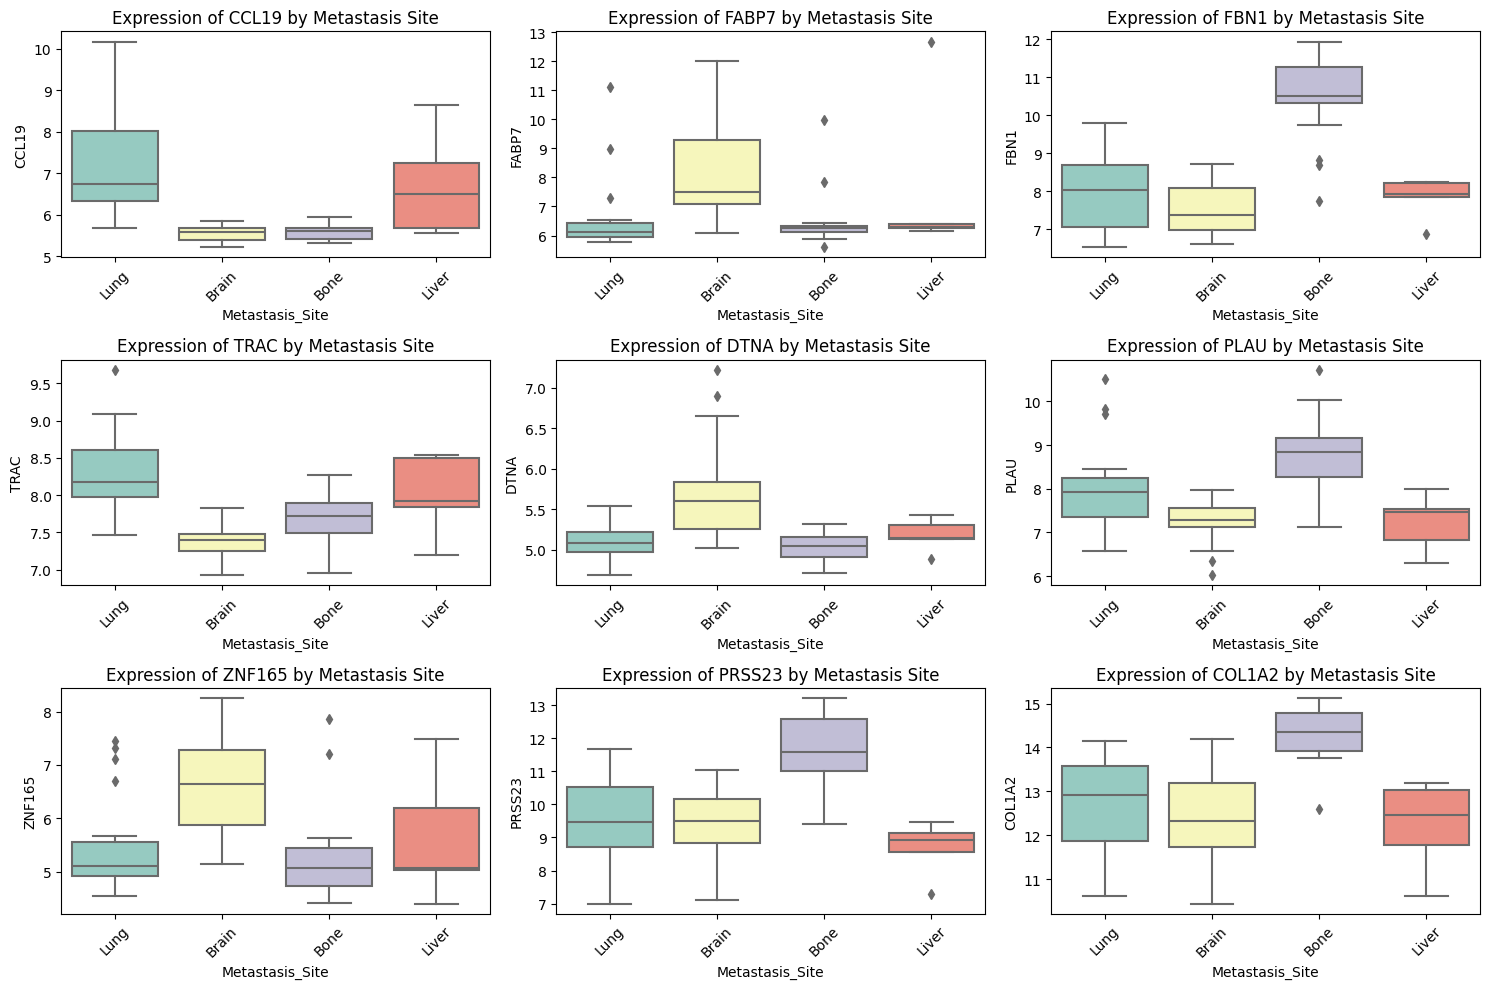

In [52]:
plt.figure(figsize=(15, 10))
for i, gene in enumerate(X_top9_df.columns[:-1], 1):  # Excluding the last column (Metastasis_Site)
    plt.subplot(3, 3, i)
    sns.boxplot(x="Metastasis_Site", y=gene, data=X_top9_df, palette="Set3")
    plt.title(f"Expression of {gene} by Metastasis Site")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


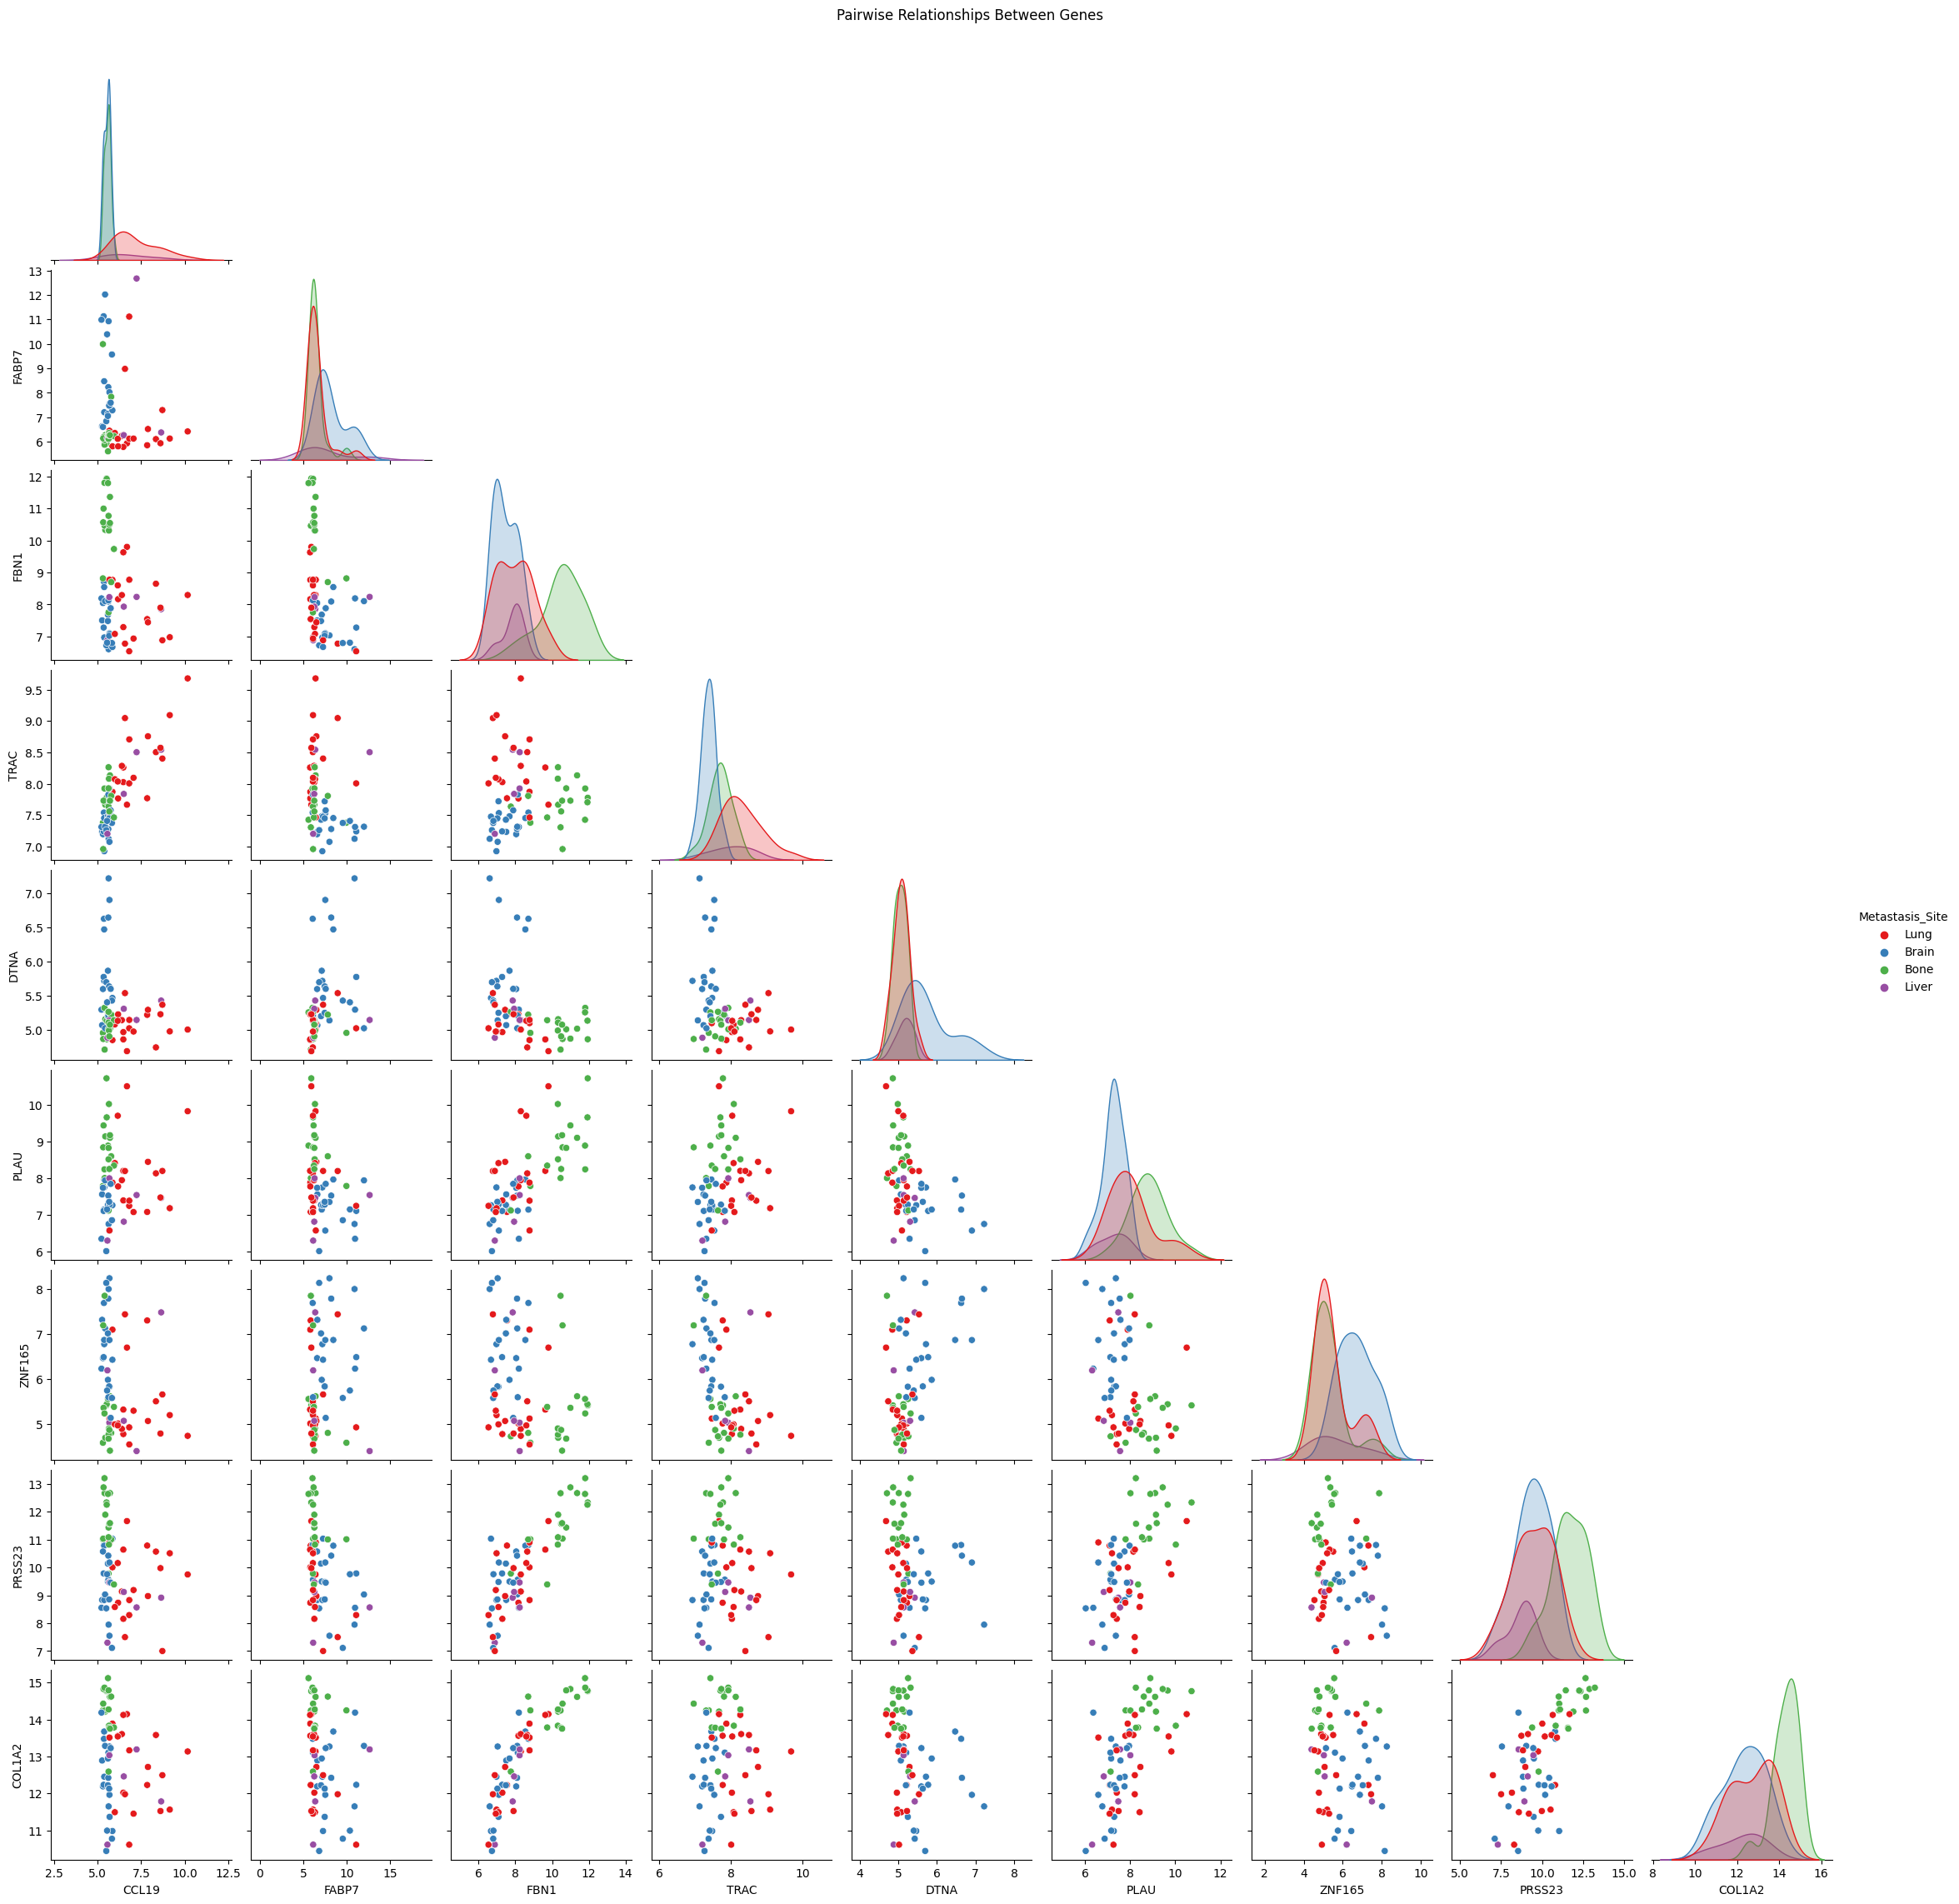

In [53]:
# Pair plot for top genes with hue set to Metastasis Site
sns.pairplot(X_top9_df, hue="Metastasis_Site", palette="Set1", diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships Between Genes", y=1.02)
plt.show()


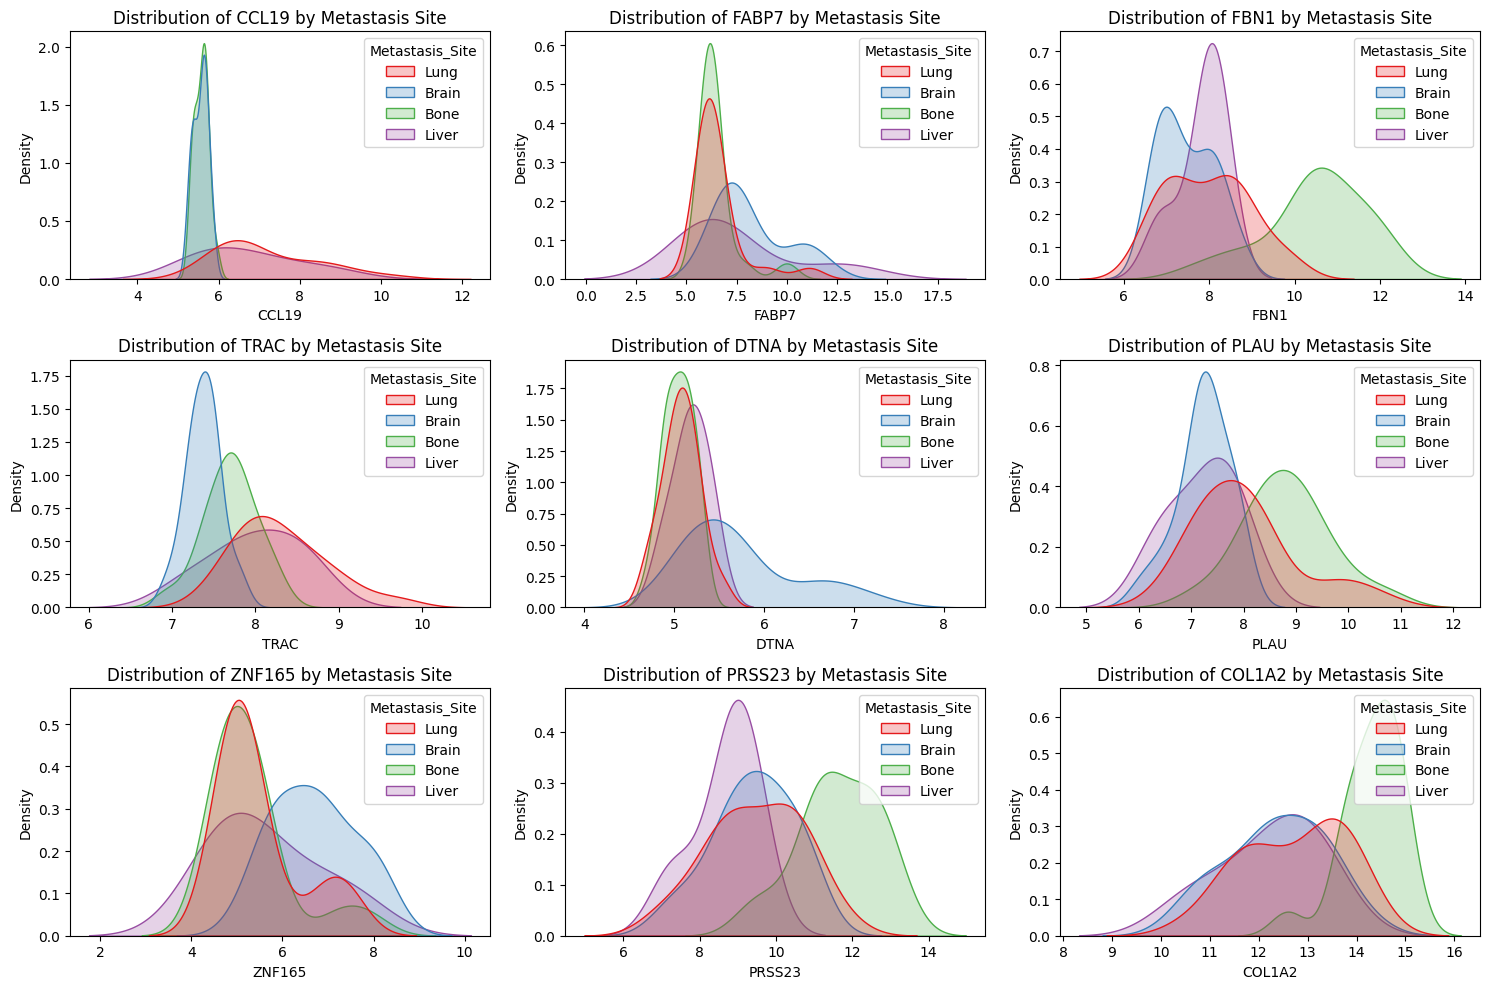

In [54]:
plt.figure(figsize=(15, 10))
for i, gene in enumerate(X_top9_df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=X_top9_df, x=gene, hue="Metastasis_Site", fill=True, common_norm=False, palette="Set1")
    plt.title(f"Distribution of {gene} by Metastasis Site")
plt.tight_layout()
plt.show()
